# Collision Prediction Analysis - VECM

In [1]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import math
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from statsmodels.tools.eval_measures import rmse, aic
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.vector_ar.vecm import VECM, select_coint_rank
from sklearn.linear_model import LinearRegression

### Considering only X and Y coordinates of all vehicles

In [2]:
data = pd.read_csv("collision4.csv")
relevant_data = data[['time', 'id', 'x', 'y']]

ego_data = relevant_data[relevant_data['id'] == 'ego_vehicle']
ego_data = ego_data.rename(columns={'x': 'ego_x', 'y': 'ego_y'}).drop('id', axis=1)

non_ego_data = relevant_data[relevant_data['id'] != 'ego_vehicle']
non_ego_pivot = non_ego_data.pivot(index='time', columns='id', values=['x', 'y'])
non_ego_pivot.columns = ['{}_{}'.format(vehicle_id,var) for var, vehicle_id in non_ego_pivot.columns]
non_ego_pivot = non_ego_pivot.reset_index()

actual_col_data = pd.merge(non_ego_pivot,ego_data, on='time', how='outer')

# Replacing NaN with -1000 
actual_col_data.fillna(-1000, inplace=True)

num_non_ego_vehicles = max(int(name.split('.')[1].split('_')[0]) for name in actual_col_data if 'non_ego_flow' in name) + 1

corrected_column_order = ['time']
for i in range(num_non_ego_vehicles):
    corrected_column_order.extend([f'non_ego_flow.{i}_x', f'non_ego_flow.{i}_y'])
corrected_column_order.extend(['ego_x', 'ego_y'])

# Reorder the columns
actual_col_data = actual_col_data[corrected_column_order]

actual_col_data.head()

,time,non_ego_flow.0_x,non_ego_flow.0_y,non_ego_flow.1_x,non_ego_flow.1_y,non_ego_flow.2_x,non_ego_flow.2_y,non_ego_flow.3_x,non_ego_flow.3_y,non_ego_flow.4_x,...,non_ego_flow.6_x,non_ego_flow.6_y,non_ego_flow.7_x,non_ego_flow.7_y,non_ego_flow.8_x,non_ego_flow.8_y,non_ego_flow.9_x,non_ego_flow.9_y,ego_x,ego_y
0,0.0,352.17,91.54,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,...,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0
1,0.1,352.17,91.54,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,...,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0
2,0.2,352.16,91.54,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,...,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0
3,0.3,352.15,91.54,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,...,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0
4,0.4,352.14,91.55,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,...,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0


In [3]:
file_path = 'col4_test.csv'
data = pd.read_csv(file_path)

def process_chunk(chunk):
    columns_to_drop = []
    for i in range(10):  
        x_col = f'non_ego_flow.{i}_x'
        y_col = f'non_ego_flow.{i}_y'
        if x_col in chunk and y_col in chunk:
            count_x = (chunk[x_col] == -1000).sum()
            count_y = (chunk[y_col] == -1000).sum()
            if count_x >= 5 or count_y >= 5:
                columns_to_drop.extend([x_col, y_col])

    if 'ego_x' in chunk and 'ego_y' in chunk:
        count_ego_x = (chunk['ego_x'] == -1000).sum()
        count_ego_y = (chunk['ego_y'] == -1000).sum()
        if count_ego_x >= 11 or count_ego_y >= 11:
            columns_to_drop.extend(['ego_x', 'ego_y'])

    return chunk.drop(columns=columns_to_drop)

chunks_dict = {}
chunk_size = 62

for i in range(0, len(data), chunk_size):
    chunk = data.iloc[i:i + chunk_size]
    processed_chunk = process_chunk(chunk)
    chunks_dict[f'chunk_{i // chunk_size + 1}'] = processed_chunk

print(list(chunks_dict.keys()))

['chunk_1', 'chunk_2', 'chunk_3', 'chunk_4', 'chunk_5', 'chunk_6', 'chunk_7', 'chunk_8', 'chunk_9', 'chunk_10', 'chunk_11', 'chunk_12', 'chunk_13']


### Considering chunk where collision occured

In [4]:
chunk_dt = chunks_dict['chunk_6'].copy()
chunk_dt

,time,non_ego_flow.1_x,non_ego_flow.1_y,non_ego_flow.2_x,non_ego_flow.2_y,non_ego_flow.3_x,non_ego_flow.3_y,non_ego_flow.4_x,non_ego_flow.4_y,non_ego_flow.5_x,...,non_ego_flow.6_x,non_ego_flow.6_y,non_ego_flow.7_x,non_ego_flow.7_y,non_ego_flow.8_x,non_ego_flow.8_y,non_ego_flow.9_x,non_ego_flow.9_y,ego_x,ego_y
310,31.0,221.41,136.30,183.97,83.13,197.81,107.58,204.33,165.53,209.37,...,202.64,170.15,107.08,224.03,214.54,130.66,257.61,144.07,246.14,178.23
311,31.1,221.41,136.30,183.39,82.10,197.24,106.58,204.35,165.52,208.91,...,202.87,170.02,108.06,223.48,214.83,131.18,257.22,144.32,246.14,178.23
312,31.2,221.41,136.30,182.81,81.08,196.67,105.57,204.37,165.50,208.44,...,203.09,169.90,109.05,222.92,215.12,131.69,256.84,144.56,246.14,178.23
313,31.3,221.41,136.30,182.23,80.05,196.09,104.55,204.39,165.49,207.97,...,203.29,169.79,110.06,222.35,215.41,132.19,256.48,144.79,246.14,178.22
314,31.4,221.41,136.30,181.66,79.04,195.51,103.53,204.41,165.48,207.50,...,203.48,169.68,111.08,221.78,215.69,132.70,256.14,145.01,246.13,178.22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367,36.7,238.80,160.22,151.24,25.28,162.97,46.01,204.65,165.34,176.34,...,206.17,168.16,172.31,183.58,222.11,160.62,251.18,148.16,238.39,157.08
368,36.8,239.38,160.93,150.65,24.24,162.34,44.91,204.65,165.34,175.68,...,206.18,168.16,173.41,182.96,221.65,161.46,251.17,148.17,238.62,156.53
369,36.9,239.94,161.61,150.06,23.21,161.72,43.81,204.65,165.34,175.01,...,206.18,168.16,174.49,182.35,221.19,162.31,251.16,148.17,238.80,156.08
370,37.0,240.48,162.26,149.47,22.17,161.09,42.70,204.65,165.34,174.35,...,206.19,168.15,175.55,181.75,220.73,163.16,251.15,148.18,238.95,155.72


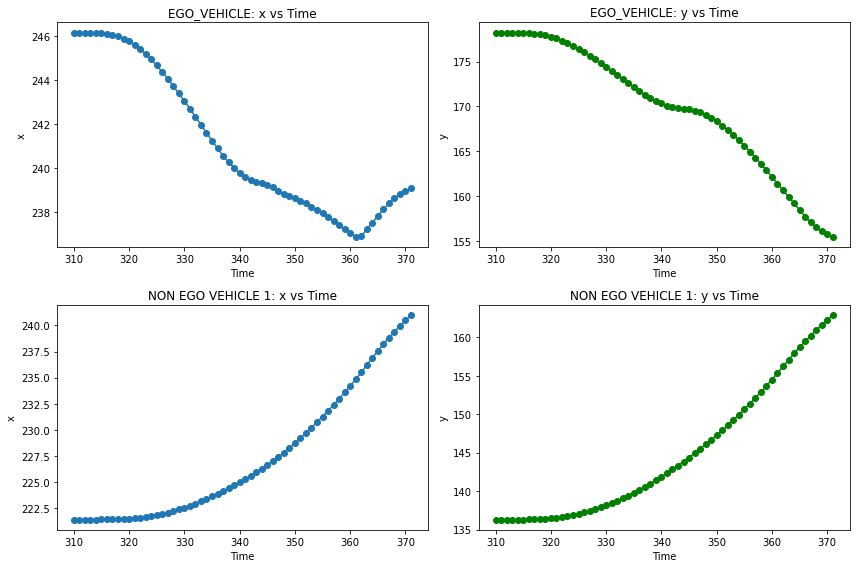

In [5]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(list(chunk_dt.index), chunk_dt['ego_x'], marker='o')
plt.title('EGO_VEHICLE: x vs Time')
plt.xlabel('Time')
plt.ylabel('x')

plt.subplot(2, 2, 2)
plt.plot(list(chunk_dt.index), chunk_dt['ego_y'], marker='o', color='green')
plt.title('EGO_VEHICLE: y vs Time')
plt.xlabel('Time')
plt.ylabel('y')

plt.subplot(2, 2, 3)
plt.plot(list(chunk_dt.index), chunk_dt['non_ego_flow.1_x'], marker='o')
plt.title('NON EGO VEHICLE 1: x vs Time')
plt.xlabel('Time')
plt.ylabel('x')

plt.subplot(2, 2, 4)
plt.plot(list(chunk_dt.index), chunk_dt['non_ego_flow.1_y'], marker='o', color='green')
plt.title('NON EGO VEHICLE 1: y vs Time')
plt.xlabel('Time')
plt.ylabel('y')

plt.tight_layout()
plt.show()

In [6]:
nobs = 20
nprev = 42
df_train_a, df_test_a = chunk_dt.iloc[0:nprev,1:6], chunk_dt.iloc[nprev:nprev+nobs,1:6]
df_train_b, df_test_b = chunk_dt.iloc[0:nprev,6:11], chunk_dt.iloc[nprev:nprev+nobs,6:11]
df_train_c, df_test_c = chunk_dt.iloc[0:nprev,11:16], chunk_dt.iloc[nprev:nprev+nobs,11:16]
df_train_d, df_test_d = chunk_dt.iloc[0:nprev,16:], chunk_dt.iloc[nprev:nprev+nobs,16:]
df_test = chunk_dt.iloc[nprev:nprev+nobs]
print(df_train_a.shape) 
print(df_test_a.shape)

(42, 5)
(20, 5)


### Cointegration_test

In [7]:
def cointegration_test(df, alpha=0.05): 
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df_train_a)
cointegration_test(df_train_b)
cointegration_test(df_train_c)
cointegration_test(df_train_d)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
non_ego_flow.1_x ::  412.68    > 60.0627   =>   True
non_ego_flow.1_y ::  259.64    > 40.1749   =>   True
non_ego_flow.2_x ::  131.12    > 24.2761   =>   True
non_ego_flow.2_y ::  61.44     > 12.3212   =>   True
non_ego_flow.3_x ::  5.49      > 4.1296    =>   True
Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
non_ego_flow.3_y ::  262.55    > 60.0627   =>   True
non_ego_flow.4_x ::  144.54    > 40.1749   =>   True
non_ego_flow.4_y ::  60.01     > 24.2761   =>   True
non_ego_flow.5_x ::  22.18     > 12.3212   =>   True
non_ego_flow.5_y ::  8.08      > 4.1296    =>   True
Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
non_ego_flow.6_x ::  432.22    > 60.0627   =>   True
non_ego_flow.6_y ::  171.85    > 40.1749   =>   True
non_ego_flow.7_x ::  71.53     > 24.2761   =>   True
non_ego_flow.7_y ::  37.57     > 12.3212   =

### Augmented Dickey-Fuller test

In [8]:
def adfuller_test(series, name):
    print(f'Augmented Dickey-Fuller Test on "{name}"')
    print('-' * 47)
    result = adfuller(series, autolag='AIC')
    labels = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']
    for value, label in zip(result, labels):
        print(f'{label} : {value}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}, {value}')
    print(f' => P-Value = {result[1]}. {"Reject" if result[1] < 0.1 else "Weak evidence to reject"} the Null Hypothesis.')
    print(f' => Series is {"Stationary" if result[1] < 0.1 else "Non-Stationary"}.\n')   
    
for name, column in df_train_a.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

Augmented Dickey-Fuller Test on "non_ego_flow.1_x"
-----------------------------------------------
ADF Test Statistic : 3.0487049263055006
p-value : 1.0
#Lags Used : 7
Number of Observations Used : 34
Critical Values:
   1%, -3.639224104416853
   5%, -2.9512301791166293
   10%, -2.614446989619377
 => P-Value = 1.0. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.



Augmented Dickey-Fuller Test on "non_ego_flow.1_y"
-----------------------------------------------
ADF Test Statistic : -1.2245187433769873
p-value : 0.6629604496210071
#Lags Used : 3
Number of Observations Used : 38
Critical Values:
   1%, -3.6155091011809297
   5%, -2.941262357486514
   10%, -2.6091995013850418
 => P-Value = 0.6629604496210071. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.



Augmented Dickey-Fuller Test on "non_ego_flow.2_x"
-----------------------------------------------
ADF Test Statistic : 2.208233583179474
p-value : 0.9988892115707789
#Lags Used 

In [9]:
coint_test_a = select_coint_rank(df_train_a, det_order=-1, k_ar_diff=5, method='trace', signif=0.05)
coint_test_b = select_coint_rank(df_train_b, det_order=-1, k_ar_diff=5, method='trace', signif=0.05)
coint_test_c = select_coint_rank(df_train_c, det_order=-1, k_ar_diff=5, method='trace', signif=0.05)
coint_test_d = select_coint_rank(df_train_d, det_order=-1, k_ar_diff=5, method='trace', signif=0.05)

### VECM Model - Vector Error Correction Model 

In [10]:
# VECM 1
vecm_a = VECM(df_train_a, coint_rank=coint_test_a.rank)  
vecm_fit_a = vecm_a.fit()
steps = 20  
forecast_a, lower_a, upper_a = vecm_fit_a.predict(steps, 0.05)

# VECM 2
vecm_b = VECM(df_train_b, coint_rank=coint_test_b.rank)  
vecm_fit_b = vecm_b.fit()
forecast_b, lower_b, upper_b = vecm_fit_b.predict(steps, 0.05)

# VECM 3
vecm_c = VECM(df_train_c, coint_rank=5)  
vecm_fit_c = vecm_c.fit()
forecast_c, lower_c, upper_c = vecm_fit_c.predict(steps, 0.05)

# VECM 4
vecm_d = VECM(df_train_d, coint_rank=3) 
vecm_fit_d = vecm_d.fit()
forecast_d, lower_d, upper_d = vecm_fit_d.predict(steps, 0.05)

df_forecast_a = pd.DataFrame(forecast_a,  columns=df_train_a.columns)
df_forecast_b = pd.DataFrame(forecast_b,  columns=df_train_b.columns)
df_forecast_c = pd.DataFrame(forecast_c,  columns=df_train_c.columns)
df_forecast_d = pd.DataFrame(forecast_d,  columns=df_train_d.columns)
df_forecast = pd.concat([df_forecast_a, df_forecast_b, df_forecast_c, df_forecast_d], axis=1)
df_forecast['time'] = list(df_test['time'])
df_forecast

,non_ego_flow.1_x,non_ego_flow.1_y,non_ego_flow.2_x,non_ego_flow.2_y,non_ego_flow.3_x,non_ego_flow.3_y,non_ego_flow.4_x,non_ego_flow.4_y,non_ego_flow.5_x,non_ego_flow.5_y,...,non_ego_flow.6_y,non_ego_flow.7_x,non_ego_flow.7_y,non_ego_flow.8_x,non_ego_flow.8_y,non_ego_flow.9_x,non_ego_flow.9_y,ego_x,ego_y,time
0,229.715461,148.554321,160.016555,40.772341,172.306074,62.516689,204.649126,165.340237,186.082711,86.853304,...,168.243157,154.149795,193.796191,222.702372,147.756887,251.409753,148.019772,238.389685,167.368768,35.2
1,230.243981,149.233552,159.445687,39.744985,171.678195,61.408613,204.648444,165.340240,185.440590,85.718598,...,168.235213,155.400239,193.035462,222.983336,148.494680,251.378628,148.040354,238.271792,166.823696,35.3
2,230.801174,149.941227,158.879231,38.719249,171.052595,60.302924,204.647076,165.340886,184.796251,84.577138,...,168.229227,156.629829,192.238369,223.273732,149.278329,251.345792,148.061918,238.159910,166.243335,35.4
3,231.387008,150.678973,158.317282,37.694897,170.425625,59.195548,204.646049,165.341522,184.147191,83.429250,...,168.223278,157.832403,191.399074,223.572087,150.113342,251.310646,148.085046,238.058017,165.636373,35.5
4,232.004993,151.449748,157.760264,36.672330,169.799761,58.088931,204.644318,165.342490,183.495106,82.274228,...,168.218358,159.007187,190.515941,223.877574,151.005787,251.272521,148.110073,237.970267,165.011296,35.6
5,232.656170,152.255757,157.208623,35.651496,169.173672,56.981684,204.642861,165.343666,182.838926,81.112661,...,168.213895,160.157345,189.591778,224.188779,151.962134,251.230869,148.137410,237.900687,164.375535,35.7
6,233.343018,153.099754,156.662638,34.632490,168.548425,55.874890,204.640909,165.345128,182.179331,79.944235,...,168.210130,161.288168,188.632321,224.504243,152.989156,251.185170,148.167373,237.852951,163.735023,35.8
7,234.066979,153.984181,156.122660,33.615201,167.923591,54.767877,204.639049,165.346823,181.515912,78.769099,...,168.206923,162.406635,187.644952,224.822359,154.093819,251.134982,148.200271,237.830172,163.093700,35.9
8,234.830045,154.911669,155.588907,32.599533,167.299694,53.661294,204.636886,165.348831,180.848965,77.587216,...,168.204330,163.519265,186.636921,225.141522,155.283196,251.079908,148.236359,237.834761,162.453239,36.0
9,235.633762,155.884678,155.061605,31.585272,166.676668,52.554792,204.634709,165.351094,180.178305,76.398611,...,168.202328,164.631346,185.614099,225.460198,156.564400,251.019605,148.275872,237.868332,161.812891,36.1


In [11]:
df_test

,time,non_ego_flow.1_x,non_ego_flow.1_y,non_ego_flow.2_x,non_ego_flow.2_y,non_ego_flow.3_x,non_ego_flow.3_y,non_ego_flow.4_x,non_ego_flow.4_y,non_ego_flow.5_x,...,non_ego_flow.6_x,non_ego_flow.6_y,non_ego_flow.7_x,non_ego_flow.7_y,non_ego_flow.8_x,non_ego_flow.8_y,non_ego_flow.9_x,non_ego_flow.9_y,ego_x,ego_y
352,35.2,229.70,148.55,160.00,40.77,172.31,62.52,204.65,165.34,186.08,...,206.03,168.24,154.14,193.82,222.70,147.74,251.42,148.01,238.39,167.37
353,35.3,230.21,149.23,159.42,39.74,171.68,61.42,204.65,165.34,185.45,...,206.05,168.23,155.40,193.11,222.98,148.45,251.39,148.03,238.25,166.84
354,35.4,230.73,149.92,158.84,38.71,171.06,60.32,204.65,165.34,184.81,...,206.06,168.23,156.66,192.40,223.27,149.18,251.37,148.04,238.10,166.26
355,35.5,231.27,150.63,158.25,37.68,170.44,59.22,204.65,165.34,184.17,...,206.07,168.22,157.91,191.70,223.32,149.98,251.35,148.06,237.95,165.63
356,35.6,231.82,151.36,157.67,36.65,169.82,58.12,204.65,165.34,183.52,...,206.09,168.21,159.16,190.99,223.32,150.82,251.33,148.07,237.78,164.97
357,35.7,232.39,152.11,157.09,35.62,169.20,57.02,204.65,165.34,182.88,...,206.10,168.21,160.40,190.29,223.31,151.68,251.31,148.08,237.60,164.29
358,35.8,232.98,152.89,156.50,34.59,168.57,55.92,204.65,165.34,182.23,...,206.11,168.20,161.64,189.60,223.30,152.56,251.29,148.09,237.43,163.59
359,35.9,233.58,153.69,155.92,33.56,167.95,54.82,204.65,165.34,181.58,...,206.12,168.19,162.87,188.90,223.29,153.45,251.28,148.10,237.24,162.87
360,36.0,234.20,154.51,155.33,32.53,167.33,53.72,204.65,165.34,180.93,...,206.13,168.19,164.09,188.21,223.29,154.36,251.26,148.11,237.06,162.14
361,36.1,234.84,155.35,154.75,31.49,166.70,52.62,204.65,165.34,180.28,...,206.13,168.18,165.31,187.53,223.28,155.27,251.25,148.12,236.87,161.39


In [12]:
mse = mean_squared_error(df_test.drop(columns=['time']), df_forecast.drop(columns=['time']), multioutput='raw_values')
mse_df = pd.DataFrame(mse,index=list(df_forecast.columns)[:-1],columns=['MSE'])
mse_df

,MSE
non_ego_flow.1_x,4.598198
non_ego_flow.1_y,4.940872
non_ego_flow.2_x,0.357967
non_ego_flow.2_y,0.026167
non_ego_flow.3_x,0.000725
non_ego_flow.3_y,0.004007
non_ego_flow.4_x,0.000505
non_ego_flow.4_y,0.000565
non_ego_flow.5_x,0.037494
non_ego_flow.5_y,0.147890


In [13]:
range_36 = df_test[(df_test['time'] >= 35.2) & (df_test['time'] <= 35.9)].mean()
range_37 = df_test[(df_test['time'] >= 36.0) & (df_test['time'] <= 36.9)].mean()
range_38 = df_test[(df_test['time'] >= 37.0) & (df_test['time'] <= 37.1)].mean()

aggregated_data = pd.DataFrame([range_36, range_37, range_38], index=['36.0', '37.0', '38.0']).drop(columns=['time'])
aggregated_data.reset_index(inplace=True)
aggregated_data.rename(columns={'index': 'Time_S'}, inplace=True)

aggregated_data.head()

,Time_S,non_ego_flow.1_x,non_ego_flow.1_y,non_ego_flow.2_x,non_ego_flow.2_y,non_ego_flow.3_x,non_ego_flow.3_y,non_ego_flow.4_x,non_ego_flow.4_y,non_ego_flow.5_x,...,non_ego_flow.6_x,non_ego_flow.6_y,non_ego_flow.7_x,non_ego_flow.7_y,non_ego_flow.8_x,non_ego_flow.8_y,non_ego_flow.9_x,non_ego_flow.9_y,ego_x,ego_y
0,36.0,231.585,151.0475,157.96125,37.165,170.12875,58.670,204.65,165.34,183.840,...,206.07875,168.21625,158.5225,191.35125,223.18625,150.4825,251.3425,148.060,237.8425,165.2275
1,37.0,237.150,158.1970,152.70100,27.871,164.52400,48.765,204.65,165.34,177.983,...,206.15700,168.17100,169.3910,185.22600,222.69000,158.4120,251.2070,148.145,237.7330,158.9160
2,38.0,240.730,162.5650,149.18000,21.650,160.78000,42.150,204.65,165.34,174.015,...,206.19000,168.15000,176.0700,181.46000,220.49500,163.5900,251.1500,148.180,239.0100,155.5800


In [14]:
range_36 = df_forecast[(df_forecast['time'] >= 35.2) & (df_forecast['time'] <= 35.9)].mean()
range_37 = df_forecast[(df_forecast['time'] >= 36.0) & (df_forecast['time'] <= 36.9)].mean()
range_38 = df_forecast[(df_forecast['time'] >= 37.0) & (df_forecast['time'] <= 37.1)].mean()

aggregated_pred_data = pd.DataFrame([range_36, range_37, range_38], index=['36.0', '37.0', '38.0']).drop(columns=['time'])
aggregated_pred_data.reset_index(inplace=True)
aggregated_pred_data.rename(columns={'index': 'Time_S'}, inplace=True)

aggregated_pred_data

,Time_S,non_ego_flow.1_x,non_ego_flow.1_y,non_ego_flow.2_x,non_ego_flow.2_y,non_ego_flow.3_x,non_ego_flow.3_y,non_ego_flow.4_x,non_ego_flow.4_y,non_ego_flow.5_x,...,non_ego_flow.6_x,non_ego_flow.6_y,non_ego_flow.7_x,non_ego_flow.7_y,non_ego_flow.8_x,non_ego_flow.8_y,non_ego_flow.9_x,non_ego_flow.9_y,ego_x,ego_y
0,36.0,231.777348,151.149689,158.051618,37.187874,170.113492,58.642145,204.644729,165.342624,183.812002,...,206.087656,168.222523,158.358950,190.856761,223.740560,150.711767,251.283545,148.102777,238.054185,165.285966
1,37.0,238.986656,159.912464,153.296190,28.041533,164.513436,48.688127,204.625724,165.362908,177.788086,...,206.213189,168.202519,168.547723,181.898634,226.532637,162.386942,250.735749,148.461987,238.327937,159.378417
2,38.0,245.596184,167.830092,150.385540,21.951763,160.839773,42.072405,204.609227,165.389357,173.628883,...,206.300700,168.212522,175.264661,175.316161,228.270727,174.726612,250.123890,148.863327,239.535589,154.405195


### Calculating minimum distance with ego_vehicle on predicted data

In [23]:
def calculate_distance(x1, y1, x2, y2):
    return np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

non_ego_columns = [col for col in aggregated_pred_data.columns if 'non_ego_flow' in col]
distance_columns = {f'rel_dist_{col}': [] for col in non_ego_columns if 'x' in col} 

for index, row in aggregated_pred_data.iterrows():
    for i in range(0, len(non_ego_columns), 2):  
        non_ego_x = row[non_ego_columns[i]]
        non_ego_y = row[non_ego_columns[i + 1]]
        distance = calculate_distance(row['ego_x'], row['ego_y'], non_ego_x, non_ego_y)
        distance_columns[f'rel_dist_{non_ego_columns[i]}'].append(distance)

distance_df_predicted = pd.DataFrame(distance_columns)
distance_df_predicted

,rel_dist_non_ego_flow.1_x,rel_dist_non_ego_flow.2_x,rel_dist_non_ego_flow.3_x,rel_dist_non_ego_flow.4_x,rel_dist_non_ego_flow.5_x,rel_dist_non_ego_flow.6_x,rel_dist_non_ego_flow.7_x,rel_dist_non_ego_flow.8_x,rel_dist_non_ego_flow.9_x
0,15.467159,151.028249,126.446994,33.409504,98.693499,32.101127,83.697049,20.427607,21.685892
1,0.848008,156.460138,133.044807,34.229421,106.171825,33.304981,73.324201,12.172934,16.526410
2,14.729517,159.661025,137.155704,36.612876,111.255141,35.988890,67.587135,23.234826,11.950916


In [24]:
def calculate_distance(x1, y1, x2, y2):
    return np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

non_ego_columns = [col for col in aggregated_data.columns if 'non_ego_flow' in col]
distance_columns = {f'rel_dist_{col}': [] for col in non_ego_columns if 'x' in col}  

for index, row in aggregated_data.iterrows():
    for i in range(0, len(non_ego_columns), 2): 
        non_ego_x = row[non_ego_columns[i]]
        non_ego_y = row[non_ego_columns[i + 1]]
        distance = calculate_distance(row['ego_x'], row['ego_y'], non_ego_x, non_ego_y)
        distance_columns[f'rel_dist_{non_ego_columns[i]}'].append(distance)

distance_df_original = pd.DataFrame(distance_columns)
distance_df_original

,rel_dist_non_ego_flow.1_x,rel_dist_non_ego_flow.2_x,rel_dist_non_ego_flow.3_x,rel_dist_non_ego_flow.4_x,rel_dist_non_ego_flow.5_x,rel_dist_non_ego_flow.6_x,rel_dist_non_ego_flow.7_x,rel_dist_non_ego_flow.8_x,rel_dist_non_ego_flow.9_x
0,15.499313,150.933820,126.252338,33.192691,98.459601,31.904051,83.511153,20.789918,21.839713
1,0.925662,156.215342,132.260351,33.700930,105.022220,32.904389,73.231449,15.051441,17.250018
2,7.193652,161.265848,137.790775,35.719283,111.051574,35.144805,68.053053,20.173382,14.217581


#### Nearest vehicles in 50 m range of ego_vehicle

In [25]:
results = {"36 sec": [],"37 sec": [],"38 sec": []}
time_list = ["36 sec","37 sec","38 sec"]
for index, row in distance_df_predicted.iterrows():
    close_vehicles = [" ".join(col.split('_')[2:5]) for col in distance_df_predicted.columns[0:] if row[col] < 50.0] 
    results[time_list[index]]= close_vehicles

results_50m = pd.DataFrame.from_dict(results, orient='index').transpose()    
results_50m

,36 sec,37 sec,38 sec
0,non ego flow.1,non ego flow.1,non ego flow.1
1,non ego flow.4,non ego flow.4,non ego flow.4
2,non ego flow.6,non ego flow.6,non ego flow.6
3,non ego flow.8,non ego flow.8,non ego flow.8
4,non ego flow.9,non ego flow.9,non ego flow.9


#### Collision Occurance if mingap (minimum distance with vehicle < 1m)

In [35]:
columns_less_than_one_meter = [col for col in distance_df_predicted.columns if (distance_df_predicted[col] < 1).any()]
vehicle_collision_with_ego = {" ".join(col.split('_')[2:5]): round(distance_df_predicted[col][distance_df_predicted[col] < 1][1],4) for col in columns_less_than_one_meter}
print(f"Collison of ego vehicle with {list(vehicle_collision_with_ego.keys())[0]} with relative distance {vehicle_collision_with_ego[list(vehicle_collision_with_ego.keys())[0]]} meters")

Collison of ego vehicle with non ego flow.1 with relative distance 0.848 meters


#### We can see that there is collision of ego_vehicle with the non ego vehicle 1, we can also verify this by the distance_df_original and simulation data